In [1]:
from logging import warning
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
tongkol = "https://docs.google.com/spreadsheets/d/1ZFY7E9F7TFotGQXeZ6fvFcn4aOoJBH1L/edit?usp=sharing&ouid=109777427362824163419&rtpof=true&sd=true".split("/")[-2]
tongkol = drive.CreateFile({'id':tongkol})
tongkol.GetContentFile('tongkol_jatim.xlsx')

In [5]:
! mkdir 'perkab'

In [6]:
data = 'tongkol_jatim.xlsx'

for sheet in range(37):
  df = pd.read_excel(data, sheet_name=sheet)
  column = ["Harga_Produsen", "Harga_Grosir", "Harga_Eceran"]

  for i in column:
    df[i] = df[i].astype(float)
  
  for i in column :
    df[i] = df[i].map(lambda x:x*1000)
  
  df.dropna(axis=0, inplace=True)

  df.to_excel(f'perkab/{sheet}.xlsx', index=False)

# Data Understanding

In [7]:
test_data = pd.read_excel('perkab/0.xlsx')
test_data.head()

,Tanggal,Provinsi,Kabupaten,Komoditas,Harga_Produsen,Harga_Grosir,Harga_Eceran
0,2014-06-04,Jawa Timur,Kab.Bangkalan,Tongkol,15000,17500,21000
1,2014-06-05,Jawa Timur,Kab.Bangkalan,Tongkol,15000,17500,21000
2,2014-06-06,Jawa Timur,Kab.Bangkalan,Tongkol,15000,17500,21000
3,2014-06-09,Jawa Timur,Kab.Bangkalan,Tongkol,15000,17500,21000
4,2014-06-10,Jawa Timur,Kab.Bangkalan,Tongkol,15000,17500,21000


In [8]:
test_data.dtypes

Tanggal           datetime64[ns]
Provinsi                  object
Kabupaten                 object
Komoditas                 object
Harga_Produsen             int64
Harga_Grosir               int64
Harga_Eceran               int64
dtype: object

In [9]:
test_data.describe()

,Harga_Produsen,Harga_Grosir,Harga_Eceran
count,395.000000,395.000000,395.000000
mean,17736.096203,20304.579747,23927.982278
std,2296.348309,2699.432930,9954.199536
min,14000.000000,16000.000000,19500.000000
25%,15500.000000,18000.000000,21000.000000
50%,18000.000000,20000.000000,24000.000000
75%,19786.000000,22813.000000,25000.000000
max,21667.000000,24565.000000,215000.000000


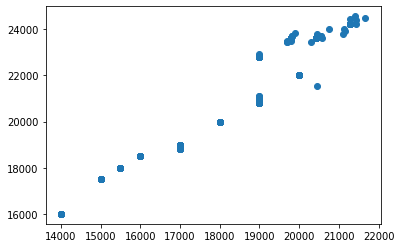

In [10]:
plt.scatter(data=test_data, x="Harga_Produsen", y="Harga_Grosir")

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.losses import MeanSquaredError as MSE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [16]:
def create_my_model1(optimizer='adam'):
  model = Sequential()
  model.add(Dense(1, input_dim=1, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='relu'))

  model.compile(loss=MSE(), optimizer=optimizer, metrics=['mean_squared_error'])
  return model

In [17]:
model = KerasClassifier(build_fn=create_my_model1) 

In [18]:
! mkdir 'saved_model'

mkdir: cannot create directory ‘saved_model’: File exists


In [29]:
for i in range(37) :

  if i == 17:
    continue

  data = pd.read_excel(f'perkab/{i}.xlsx')
  X = data["Harga_Produsen"].to_numpy()
  y = data["Harga_Grosir"].to_numpy()
  y = y.reshape(-1, 1)

  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

  print(f"Data ke-{i}")
  history = model.fit(x_train, y_train, epochs=5, batch_size=20)
  
  if history.history['mean_squared_error'][4] < 5:
    history.model.save(f'saved_model/{i}.h5')

Data ke-0
Epoch 1/5
16/16 [==============================] - 1s 3ms/step - loss: 135.1614 - mean_squared_error: 135.1614
Epoch 2/5
16/16 [==============================] - 0s 3ms/step - loss: 135.1614 - mean_squared_error: 135.1614
Epoch 3/5
16/16 [==============================] - 0s 3ms/step - loss: 135.1614 - mean_squared_error: 135.1614
Epoch 4/5
16/16 [==============================] - 0s 3ms/step - loss: 135.1614 - mean_squared_error: 135.1614
Epoch 5/5
16/16 [==============================] - 0s 3ms/step - loss: 135.1614 - mean_squared_error: 135.1614
Data ke-1
Epoch 1/5
17/17 [==============================] - 0s 3ms/step - loss: 79.9059 - mean_squared_error: 79.9059
Epoch 2/5
17/17 [==============================] - 0s 2ms/step - loss: 79.9059 - mean_squared_error: 79.9059
Epoch 3/5
17/17 [==============================] - 0s 3ms/step - loss: 79.9059 - mean_squared_error: 79.9059
Epoch 4/5
17/17 [==============================] - 0s 2ms/step - loss: 79.9059 - mean_squared_erro